<a href="https://colab.research.google.com/github/sahar7888/NLP_LLM_Projects/blob/main/Movie_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain
!pip install chromadb
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#%% packages
import re
import pandas as pd
import seaborn as sns
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from pprint import pprint

In [ ]:
def max_word_count(txt_list:list):
    max_length = 0
    for txt in txt_list:
        word_count = len(re.findall(r'\w+', txt))
        if word_count > max_length:
            max_length = word_count
    return f"Max Word Count: {max_length} words"

In [ ]:
model_max_chunk_length = 256
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=model_max_chunk_length,
    model_name="all-MiniLM-L6-v2",
    chunk_overlap=0
)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# %% Data Import
text_path = "/content/movies.csv"
df_movies_raw = pd.read_csv(text_path, parse_dates=['release_date'])

df_movies_raw.head(2)

#%% filter movies for missing title or overwiew
selected_cols = ['id', 'title', 'overview', 'vote_average', 'release_date']
df_movies_filt = df_movies_raw[selected_cols].dropna()
# filter for unique ids
df_movies_filt = df_movies_filt.drop_duplicates(subset=['id'])

# filter for movies after 01.01.2023
df_movies_filt = df_movies_filt[df_movies_filt['release_date'] > '2023-01-01']
df_movies_filt.shape
#%%

(1112, 5)

In [ ]:
max_word_count(df_movies_filt['overview'])

#%% Word Distribution
descriptions_len = []
for txt in df_movies_filt.loc[:, "overview"]:
    descriptions_len.append(len(re.findall(r'\w+', txt)))

<Axes: ylabel='Count'>

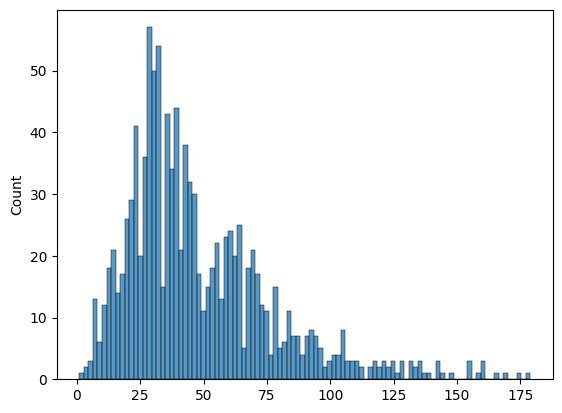

In [ ]:
#%% visualize token distribution
sns.histplot(descriptions_len, bins=100)

In [ ]:
# %%
embedding_fn = SentenceTransformerEmbeddingFunction()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# persistent
chroma_db = chromadb.PersistentClient(path="db")

In [ ]:
#%%
chroma_db.list_collections()
#%% Get / Create Collection
# chroma_collection = chroma_db.create_collection("movies", embedding_function=embedding_fn)
# chroma_collection = chroma_db.get_collection("movies")
chroma_collection = chroma_db.get_or_create_collection("movies")
# %% add all tokens to collection
ids = [str(i) for i in df_movies_filt['id'].tolist()]
documents = df_movies_filt['overview'].tolist()
titles = df_movies_filt['title'].tolist()
metadatas = [{'source': title} for title in titles]
#%%
chroma_collection.add(documents=documents, ids=ids, metadatas=metadatas)


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 40.6MiB/s]


In [ ]:
#%% count of documents in collection
len(chroma_collection.get()['ids'])

1112

In [ ]:
# %% Run a Query
def get_title_by_description(query_text:str):
    n_results = 3
    res = chroma_collection.query(query_texts=[query_text], n_results=n_results)
    for i in range(n_results):
        pprint(f"Title: {res['metadatas'][0][i]['source']} \n")
        pprint(f"Description: {res['documents'][0][i]} \n")
        pprint("-------------------------------------------------")

In [ ]:
#%% Run a Query
get_title_by_description(query_text="love, underwater")

'Title: Meg 2: The Trench \n'
('Description: An exploratory dive into the deepest depths of the ocean of a '
 'daring research team spirals into chaos when a malevolent mining operation '
 'threatens their mission and forces them into a high-stakes battle for '
 'survival. \n')
'-------------------------------------------------'
'Title: Hidden Dragon \n'
('Description: In a magical undersea world where dragons rule and humans are '
 "feared a naive young dragon forms an uneasy alliance with the sea's greatest "
 'enemy - a human girl. \n')
'-------------------------------------------------'
"Title: Let's Meet Halfway \n"
('Description: A film by Dana Dveris and Max Schmitz about a long distance '
 'couple falling out of love set in Northern CA. Charlie and Avery meet once a '
 'month in a rural town between them in an attempt to preserve their love. '
 'Over the course of six trips to meet one another long-held secrets bubble to '
 'the surface and their relationship will never be the 

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=53fea351b2d95129969d5b44566247d1a4feb094180cb16af023fc0bdc51ba80
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0


In [ ]:
# Install necessary libraries
%%writefile app.py

import re
import pandas as pd
import seaborn as sns
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from pprint import pprint
import gradio as gr

##Functions
def max_word_count(txt_list:list):
    max_length = 0
    for txt in txt_list:
        word_count = len(re.findall(r'\w+', txt))
        if word_count > max_length:
            max_length = word_count
    return f"Max Word Count: {max_length} words"
###
model_max_chunk_length = 256
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=model_max_chunk_length,
    model_name="all-MiniLM-L6-v2",
    chunk_overlap=0

)
####
# %% Data Import
text_path = "movies.csv"
df_movies_raw = pd.read_csv(text_path, parse_dates=['release_date'])

# df_movies_raw.head(2)

#%% filter movies for missing title or overwiew
selected_cols = ['id', 'title', 'overview', 'vote_average', 'release_date']
df_movies_filt = df_movies_raw[selected_cols].dropna()
# filter for unique ids
df_movies_filt = df_movies_filt.drop_duplicates(subset=['id'])

# filter for movies after 01.01.2023
df_movies_filt = df_movies_filt[df_movies_filt['release_date'] > '2023-01-01']


# %%Word Embedding
embedding_fn = SentenceTransformerEmbeddingFunction()

# persistent
chroma_db = chromadb.PersistentClient(path="db")

#%%
chroma_db.list_collections()
#%% Get / Create Collection
# chroma_collection = chroma_db.create_collection("movies", embedding_function=embedding_fn)
# chroma_collection = chroma_db.get_collection("movies")
chroma_collection = chroma_db.get_or_create_collection("movies")
# %% add all tokens to collection
ids = [str(i) for i in df_movies_filt['id'].tolist()]
documents = df_movies_filt['overview'].tolist()
titles = df_movies_filt['title'].tolist()
metadatas = [{'source': title} for title in titles]
#%%
chroma_collection.add(documents=documents, ids=ids, metadatas=metadatas)

# %% Run a Query
def get_title_by_description(query_text: str):
    n_results = 3
    results = []
    res = chroma_collection.query(query_texts=[query_text], n_results=n_results)
    for i in range(n_results):
        title = res['metadatas'][0][i]['source']
        description = res['documents'][0][i]
        results.append(f"Title: {title}\nDescription: {description}\n")

    return "\n\n".join(results)

# Create the Gradio interface
iface = gr.Interface(
    fn=get_title_by_description,
    inputs=gr.Textbox(lines=2, placeholder="Enter query text here..."),
    outputs=gr.Textbox(label="Results"),
    title="Query Description and Title",
    description="Enter a query to get the corresponding descriptions per title."
)

# Launch the interface
iface.launch()








Writing app.py
